# Non-linear Gaussian filtering and smoothing (continuous-discrete)

Provided is an example of a nonlinear state-space model on which one can perform Bayesian filtering and smoothing in order to obtain
a posterior distribution over a latent state trajectory based on noisy observations.
In order to understand the theory behind these methods in detail we refer to [1] and [2].

In order to perform Bayesian Filtering and Smoothing on non-linear models, we show how to use functionalities provided by ProbNum to
either linearise the respective model (Extended Kalman Filter, EKF) or to use an Unscented Transform (Unscented Kalman Filter, UKF) which does not require a Jacobian of the nonlinear model.

**References**:
> [1] Särkkä, Simo, and Solin, Arno. Applied Stochastic Differential Equations. Cambridge University Press, 2019.  
>
> [2] Särkkä, Simo. Bayesian Filtering and Smoothing. Cambridge University Press, 2013.

In [1]:
import numpy as np

import probnum as pn
from probnum import filtsmooth, randvars, randprocs
from probnum.problems import TimeSeriesRegressionProblem

In [2]:
rng = np.random.default_rng(seed=123)

In [3]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.style.use("../../probnum.mplstyle")

/tmp/ipykernel_18296/236124620.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "svg")


## **Non-Linear Continuous-Discrete** State-Space Model: Benes-Daum Filter

Now, consider we assume **continuous** dynamics. We assume that there is a continuous process that defines the nonlinear dynamics of our latent space from which we collect discrete nonlinear-Gaussian measurements (as above). Only the dynamics model changes. In particular, we formulate the dynamics as a stochastic process in terms of a Nonlinear Time-Invariant Stochastic Differential Equation. We refer to [1] for more details.
Again, consider non-linear functions $f: \mathbb{R}^d \rightarrow \mathbb{R}^d$ and $h: \mathbb{R}^d \rightarrow \mathbb{R}^m$ where $d$ is the dimension of the latent state and
$m$ is the dimension of the measurements.
We define the following nonlinear **continuous-discrete** state-space model:

Let $x(t_0) \sim \mathcal{N}(\mu_0, \Sigma_0)$.

$$
\begin{align}
    d\boldsymbol{x} &= f(\boldsymbol{x}) \, dt + \boldsymbol{L} \, d \boldsymbol{\omega} \\
    \boldsymbol{y}_k &\sim \mathcal{N}(h(\boldsymbol{x}(t_k)), \boldsymbol{R}), \qquad k = 1, \dots, K
\end{align}
$$

where $\boldsymbol{\omega}$ denotes a vector of driving forces (often Brownian Motion).


Note that this can be generalized to a nonlinear time-varying state-space model, as well. Then we would have $f: \mathbb{T} \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ and $h: \mathbb{T} \times \mathbb{R}^d \rightarrow \mathbb{R}^m$ where $\mathbb{T}$ is the "time dimension".

### Define State-Space Model

#### I. Continuous Dynamics Model: Nonlinear Stochastic Differential Equation

In [4]:
state_dim = 1
observation_dim = 1

In [5]:
drift_function = lambda t, state: np.tanh(state)
drift_function_jacobian = lambda t, state: 1.0 - np.tanh(state) ** 2

dispersion_function = lambda t, x: np.ones(state_dim).reshape(1, 1)

For continous, non-linear dynamics, `probnum` provides a general stochastic differential equation (SDE) interfaces.

In [6]:
# Create continuous, non-linear SDE dynamics model
dynamics_model = randprocs.markov.continuous.SDE(
    state_dimension=state_dim,
    wiener_process_dimension=1,
    drift_function=drift_function,
    dispersion_function=dispersion_function,
    drift_jacobian=drift_function_jacobian,
)

#### II. Discrete Measurement Model: Linear, Time-Invariant, Gaussian Measurements

In [7]:
measurement_marginal_variance = 1.0
measurement_matrix = np.eye(observation_dim, state_dim)
measurement_noise_matrix = measurement_marginal_variance * np.eye(observation_dim)

In [8]:
measurement_model = randprocs.markov.discrete.LTIGaussian(
    transition_matrix=measurement_matrix,
    noise = randvars.Normal(np.zeros(observation_dim), measurement_noise_matrix),
)

#### III. Initial State Random Variable

In [9]:
mu_0 = np.zeros(state_dim)
sigma_0 = 3.0 * np.eye(state_dim)
initial_state_rv = randvars.Normal(mean=mu_0, cov=sigma_0)

### Kalman Filtering

#### I. Linearize model (Extended Kalman Filter)

In [10]:
linearised_dynamics_model = filtsmooth.gaussian.approx.ContinuousEKFComponent(
    dynamics_model
)

#### II. Kalman Filter

In [11]:
prior_process = randprocs.markov.MarkovProcess(
    transition=linearised_dynamics_model, initrv=initial_state_rv, initarg=0.0
)
kalman_filter = filtsmooth.gaussian.ContinuousKalman(prior_process)

#### III. Generate Data for the State-Space Model

`generate_artificial_measurements()` is used to sample both latent states and noisy observations from the specified state space model.

In [12]:
delta_t = 0.01
time_grid = np.arange(0.0, 10.0, step=10 * delta_t)

In [13]:
latent_states, observations = randprocs.markov.utils.generate_artificial_measurements(
    rng=rng,
    prior_process=prior_process,
    measmod=measurement_model,
    times=time_grid,
)

In [14]:
regression_problem = TimeSeriesRegressionProblem(
    observations=observations,
    locations=time_grid,
    measurement_models=[measurement_model] * len(time_grid),
)

#### IV. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [15]:
state_posterior, _ = kalman_filter.filter(regression_problem)

In [16]:
smoothed_state_posterior = kalman_filter.smooth(filter_posterior=state_posterior)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [17]:
grid = np.linspace(0, 11, 500)

posterior_state_rvs = state_posterior(
    grid
)  # List of <num_time_points> Normal Random Variables
posterior_state_means = (
    posterior_state_rvs.mean.squeeze()
)  # Shape: (num_time_points, state_dim)
posterior_state_covs = (
    posterior_state_rvs.cov
)  # Shape: (num_time_points, state_dim, state_dim)

In [18]:
smoothed_posterior_state_rvs = (
    smoothed_state_posterior.states
)  # List of <num_time_points> Normal Random Variables
smoothed_posterior_state_means = (
    smoothed_posterior_state_rvs.mean.squeeze()
)  # Shape: (num_time_points, state_dim)
smoothed_posterior_state_covs = (
    smoothed_posterior_state_rvs.cov
)  # Shape: (num_time_points, state_dim, state_dim)

### Visualize Results

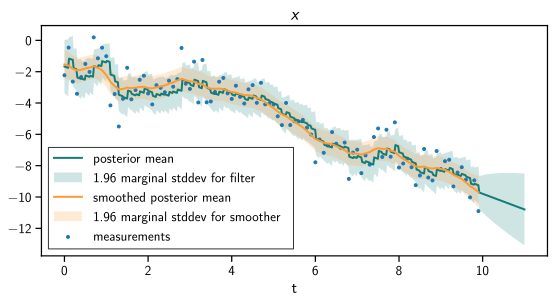

In [19]:
state_fig = plt.figure()

ax = state_fig.add_subplot()

# Plot means
ax.plot(grid, posterior_state_means, label="posterior mean")

# Plot marginal standard deviations
std_x = np.sqrt(np.abs(posterior_state_covs)).squeeze()
ax.fill_between(
    grid,
    posterior_state_means - 1.96 * std_x,
    posterior_state_means + 1.96 * std_x,
    alpha=0.2,
    label="1.96 marginal stddev for filter",
)

# Plot smoothed means
ax.plot(time_grid, smoothed_posterior_state_means, label="smoothed posterior mean")

# Plot marginal standard deviations
std_x = np.sqrt(smoothed_posterior_state_covs).squeeze()
ax.fill_between(
    time_grid,
    smoothed_posterior_state_means - 1.96 * std_x,
    smoothed_posterior_state_means + 1.96 * std_x,
    alpha=0.2,
    label="1.96 marginal stddev for smoother",
)

ax.scatter(time_grid, observations, marker=".", label="measurements")

# Add labels etc.
ax.set_xlabel("t")
ax.set_title(r"$x$")
ax.legend()

state_fig.tight_layout()

To get a closer look at filter and smoother, we inspect the interval $[0, 1]$ in greater detail.

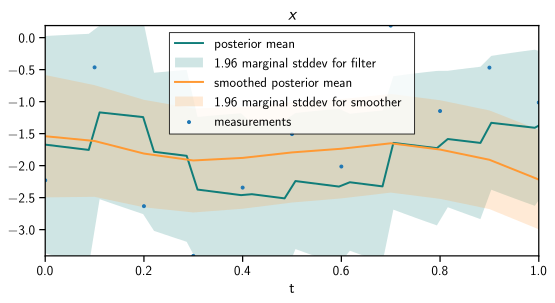

In [20]:
idx = time_grid < 1.0

ax.set_xlim([0, 1])
ax.set_ylim(np.min(observations[idx]), np.max(observations[idx]))

state_fig.tight_layout()
state_fig